In [1]:
import os, time
import sys
sys.path.insert(1, '../')
from concentration import clt_iid, binomial_iid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [2]:
# The classification algorithm
def find_ellipse(filename, plot):
    img_full = cv.imread(filename, cv.IMREAD_COLOR)

    cropRows = [-img_full.shape[0]//3, -img_full.shape[0]//6]
    cropCols = [-img_full.shape[1]//5, -img_full.shape[1]//15]

    img = img_full[cropRows[0]:cropRows[1],cropCols[0]:cropCols[1],:]


    # Check if image is loaded fine
    if img is None:
        print ('Error opening image!')
        print ('Usage: hough_circle.py [image_name -- default ' + default_file + '] \n')


    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    gray = 255-gray

    rows = gray.shape[0]

    contours,hierarchy = cv.findContours(gray,2,1)
    contours_passed = []
    fit_ellipses = []
    areas = []
    area_constraints = [250,1500]
    for i in contours:
        area = cv.contourArea(i) 
        if(area >= area_constraints[0] and area <= area_constraints[1]):
            contours_passed += [i]
            curr_ell = cv.fitEllipse(i)
            fit_ellipses += [curr_ell]
            areas += [area]
    contours_passed, areas = np.array(contours_passed), np.array(areas)
    analytic_areas = np.array([ell[1][0]*ell[1][1]*np.pi/4.0 for ell in fit_ellipses])
    if areas.shape[0] == 0:
        vote = -1
    else:
        idx_best = np.argmin( np.abs(analytic_areas - areas)/areas )
        ell_best = fit_ellipses[idx_best]
        decision_boundary = int(img.shape[0]/1.5)
        vote = fit_ellipses[idx_best][0][1] >= decision_boundary
        if plot:
            cv.line(img, (0,decision_boundary), (img.shape[1]-1,decision_boundary), (255,0,0), 2)
            cv.ellipse(img, fit_ellipses[idx_best], (0,255,0), -1)

    if plot:
        img_full[cropRows[0]:cropRows[1],cropCols[0]:cropCols[1],:] = img

        plt.figure(figsize=(15,15))
        plt.imshow(img_full)
        plt.axis('off');
    
    return vote

In [3]:
# Process .tif images into .png
base_path = "/Users/angelopoulos/Code/working/prediction-powered-inference/ballots/raw/A22_BallotImages"
new_path = "/Users/angelopoulos/Code/working/prediction-powered-inference/ballots/proc/"
ballot_dirnames = []
ballot_filenames = []
os.makedirs(new_path, exist_ok = True)
counter = 1
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.tif' in filename:
            ballot_dirnames += [dirpath,]
            ballot_filenames += [filename,]

for i in tqdm(range(len(ballot_filenames))):
    if not os.path.exists(new_path + str(counter) + ".png"):
        img_full = cv.imread(ballot_dirnames[i] + "/" + ballot_filenames[i], cv.IMREAD_COLOR)
        cv.imwrite(new_path + str(counter) + ".png", img_full)
    counter += 1

100%|██████████████████████████████████████████████████████████████████████████| 78771/78771 [00:01<00:00, 58967.03it/s]


In [4]:
# Read in and clean labels
cal_label_csv = pd.read_csv('labels.csv')
cal_labeled_image_filenames = [new_path + cal_label_csv['image'][i].split("/")[3] for i in range(len(cal_label_csv))]
cal_labels = -np.ones((len(cal_label_csv,)))
cal_labels[cal_label_csv['choice'] == "Matt Haney"] = 1
cal_labels[cal_label_csv['choice'] == "David Campos"] = 0

cal_preds = np.array([find_ellipse(fname, plot=False) for fname in cal_labeled_image_filenames])
clean_cal_preds = cal_preds[(cal_labels >= 0) & (cal_preds >= 0)]
clean_cal_labels = cal_labels[(cal_labels >= 0) & (cal_preds >= 0)]

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_7364/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


In [5]:
# Model accuracy
print(f"Model accuracy: {(clean_cal_preds == clean_cal_labels).astype(float).mean()*100:.2f}%")

Model accuracy: 99.12%


In [7]:
# Do the counting
base_path = "/Users/angelopoulos/Code/working/prediction-powered-inference/ballots/proc/"
plot = False
ballot_filenames = []
print_rate = 100
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.png' in filename:
            ballot_filenames += [dirpath + "/" + filename, ]
# Count the prediction-powered votes
vote_counts = np.array([0,0,0])
for i in range(len(ballot_filenames)):
    ballot_filename = ballot_filenames[i]
    if ballot_filename in cal_labeled_image_filenames: # Don't count the ones we already labeled
        continue
    else:
        vote = find_ellipse(ballot_filename, plot=plot)
        if vote >= 0:
            vote_counts[int(vote)] += 1
        else:
            vote_counts[2] += 1
        if i % print_rate == 0:
            print(f"Vote Count ({float(i)/float(len(ballot_filenames))*100:.2f}% counted): Haney {vote_counts[1]} ({vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Campos {vote_counts[0]} ({100-vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Thrown Out {vote_counts[2]} ({vote_counts[2]/vote_counts.sum()*100:.2f}%)", end="\r")

print("\n")
print(f"Final Count ({float(i)/float(len(ballot_filenames))*100:.2f}% counted): Haney {vote_counts[1]} ({vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Campos {vote_counts[0]} ({100-vote_counts[1]/(vote_counts[0]+vote_counts[1])*100:.2f}%), Thrown Out {vote_counts[2]} ({vote_counts[2]/vote_counts.sum()*100:.2f}%)", end="\r")

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_11218/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


KeyboardInterrupt: 

In [6]:
## Set up inference parameters
alpha = 0.05
delta = 0.04
N = 30292 + 47858 # Total number of ballots
n_max = 1000 # Total number of labeled ballots
ns = np.linspace(100,n_max,20).astype(int)
grid = np.linspace(0.3,0.7,1000)
vote_counts = np.array([30292, 47858, 621]) # From last cell
num_trials = 500

# Reported result (official outcome)
reported_estimate = 0.6237

# Imputed-only estimate
imputed_estimate = vote_counts[1]/N

# Run prediction-powered inference and classical inference for many values of n
ci = np.zeros((num_trials, ns.shape[0], 2))
ci_classical = np.zeros((num_trials, ns.shape[0], 2))

for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n)
        f = clean_cal_preds.astype(float)[rand_idx[:n]]
        y = clean_cal_labels.astype(float)[rand_idx[:n]]

        rectifier = -(f - y).mean() # negative bias
        
        muf_ci = binomial_iid(N,alpha-delta,imputed_estimate)
        rec_ci = 2*clt_iid((-(f - y) + 1)/2, delta)-1
        
        ci[j,i,:] = [muf_ci[0]+rec_ci[0], muf_ci[1]+rec_ci[1]]

        # Classical interval
        ci_classical[j,i,:] = binomial_iid(n,alpha,y.mean())
        
ci_naiveML = binomial_iid(N, alpha, imputed_estimate)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


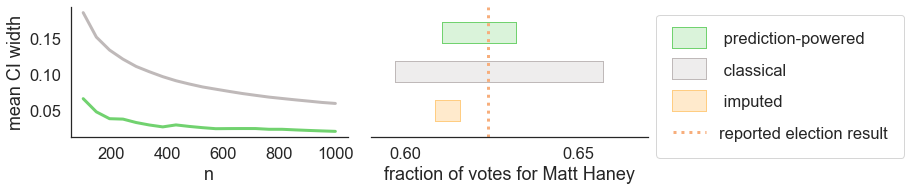

In [8]:
# Plots
os.makedirs('./figures', exist_ok=True)
sns.set_theme(style='white', font_scale=1.5)

avg_ci = ci.mean(axis=0)[-1]
avg_ci_classical = ci_classical.mean(axis=0)[-1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))

# Intervals
axs[1].plot(avg_ci,[0.4,0.4], linewidth=20, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#71D26F"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
axs[1].plot(avg_ci_classical,[0.25, 0.25], linewidth=20, color="#EEEDED", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#BFB9B9"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
axs[1].plot(ci_naiveML,[0.1, 0.1], linewidth=20, color="#FFEACC", path_effects=[pe.Stroke(linewidth=22, offset=(-1,0), foreground="#FFCD82"), pe.Stroke(linewidth=22, offset=(1,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
axs[1].axvline(reported_estimate, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="reported election result", color="#F7AE7C")
axs[1].set_xlabel("fraction of votes for Matt Haney")
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].xaxis.set_tick_params()
axs[1].set_ylim([0,0.5])
axs[1].set_xlim([0.59, 0.67])
axs[1].locator_params(nbins=3)
axs[1].legend(borderpad=1, labelspacing=1, bbox_to_anchor=(1,1))
sns.despine(ax=axs[1],top=True,right=True,left=True)

# Lines
axs[0].plot(ns,ci.mean(axis=0)[:,1]-ci.mean(axis=0)[:,0], label="prediction-powered", color="#71D26F", linewidth=3)
axs[0].plot(ns, ci_classical.mean(axis=0)[:,1]-ci_classical.mean(axis=0)[:,0], label="classical", color="#BFB9B9", linewidth=3)
axs[0].locator_params(axis='y', tight=None, nbins=6)
axs[0].set_ylabel("mean CI width")
axs[0].set_xlabel("n")
sns.despine(ax=axs[0],top=True, right=True)
plt.tight_layout()

plt.savefig('./results.pdf')

/var/folders/nf/9jh22yw56mj181378_s3p7vr0000gn/T/ipykernel_59536/2661563666.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_passed, areas = np.array(contours_passed), np.array(areas)


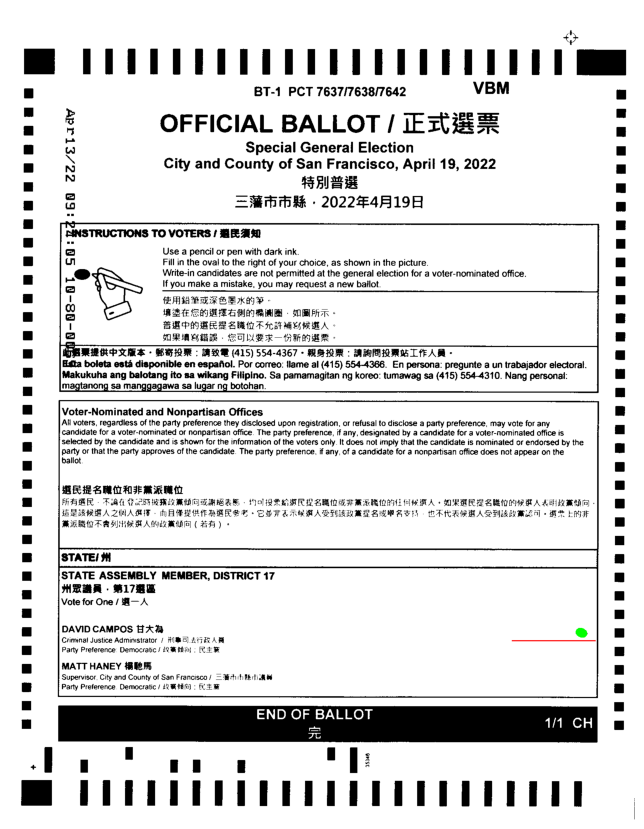

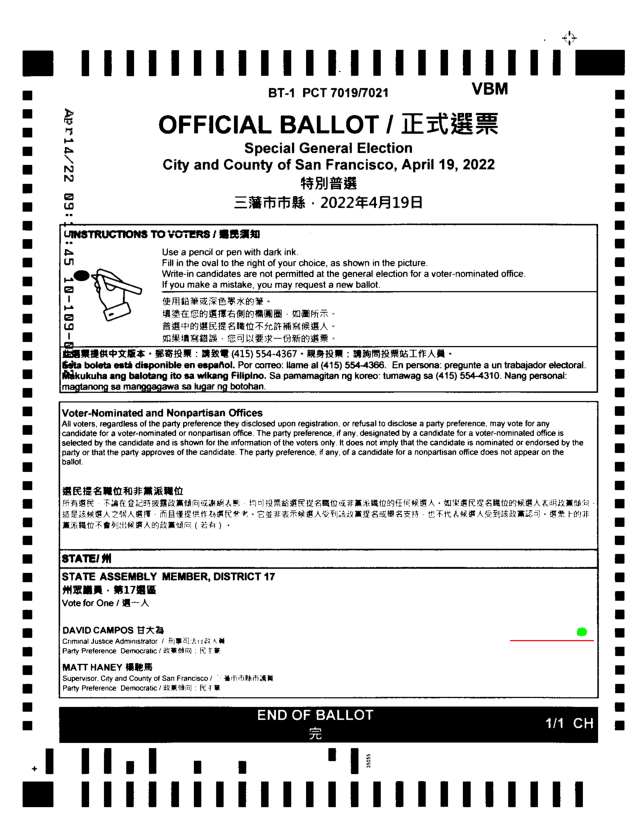

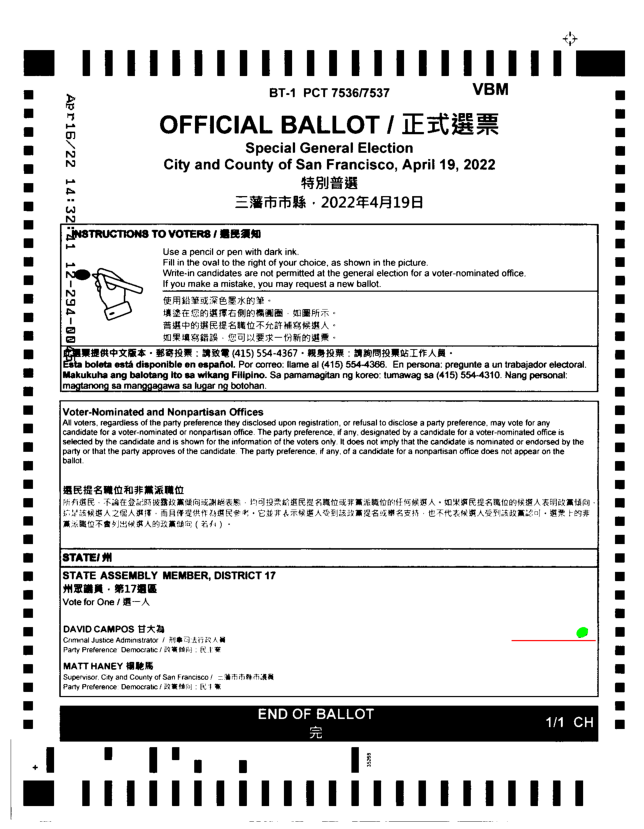

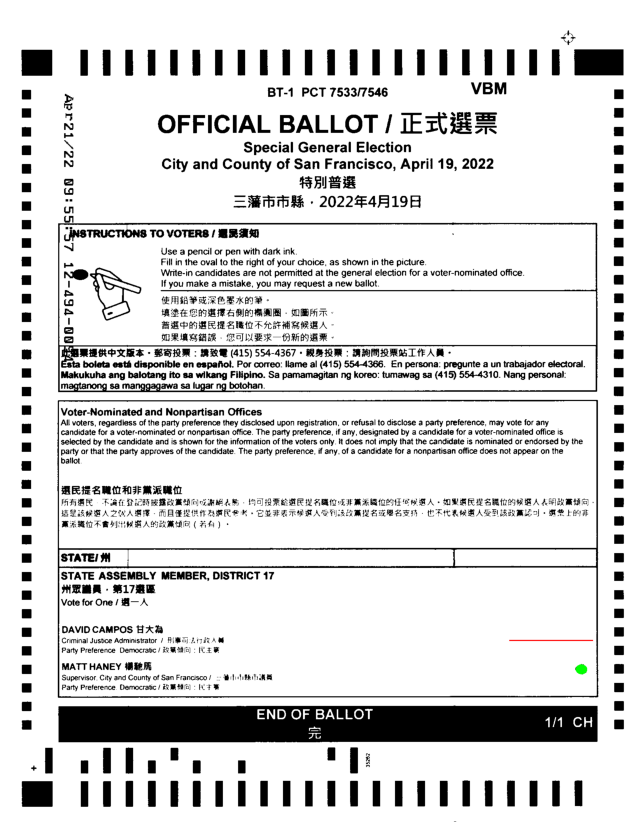

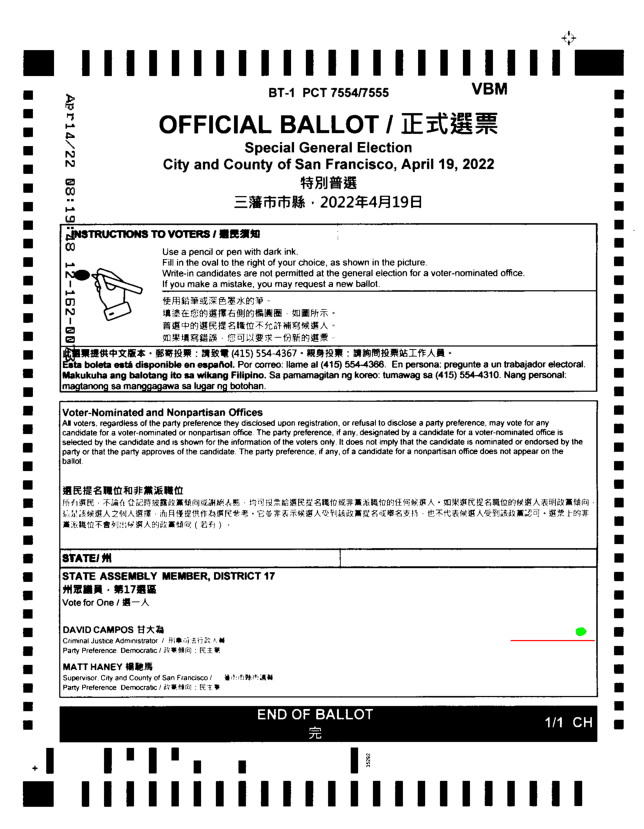

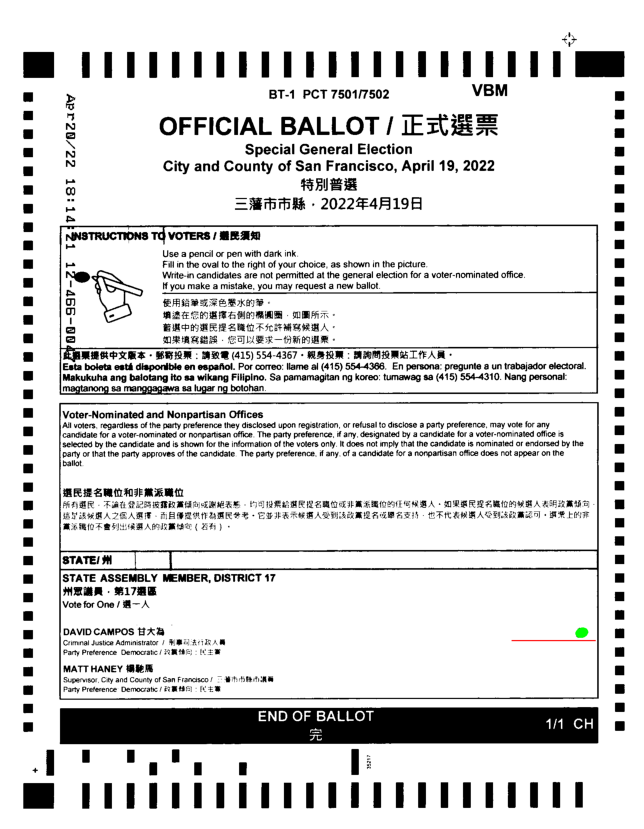

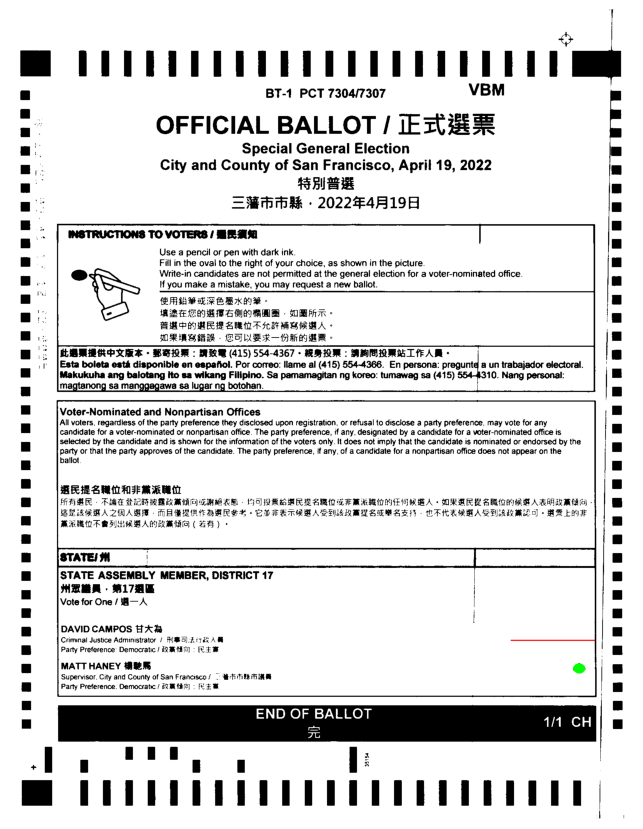

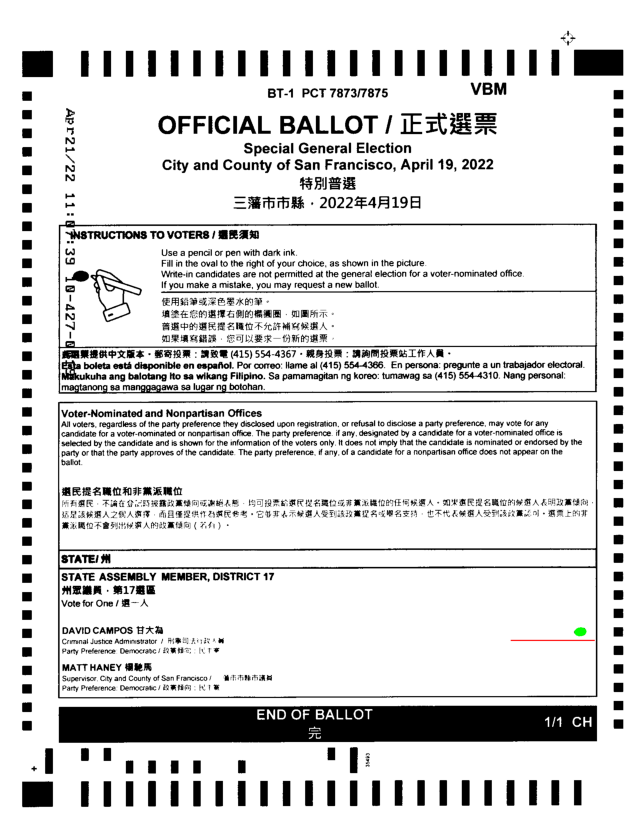

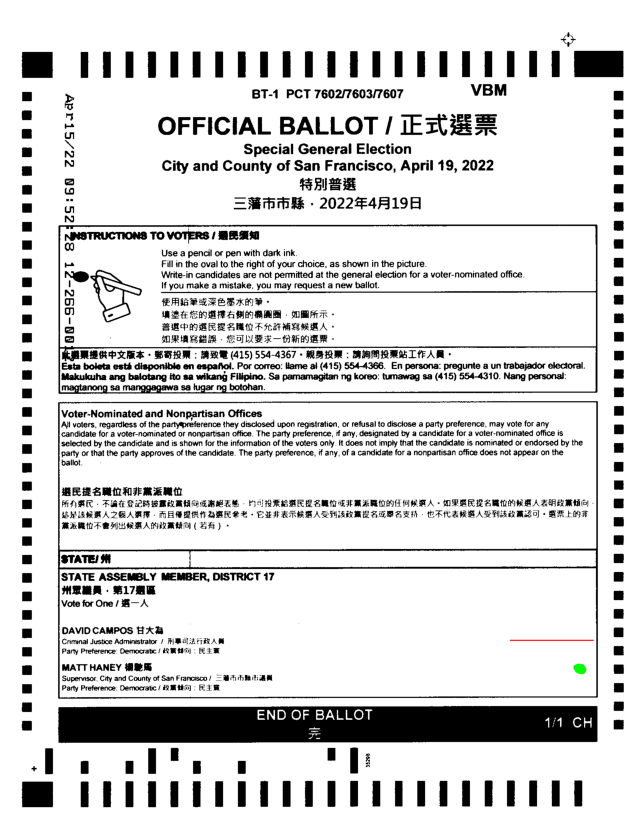

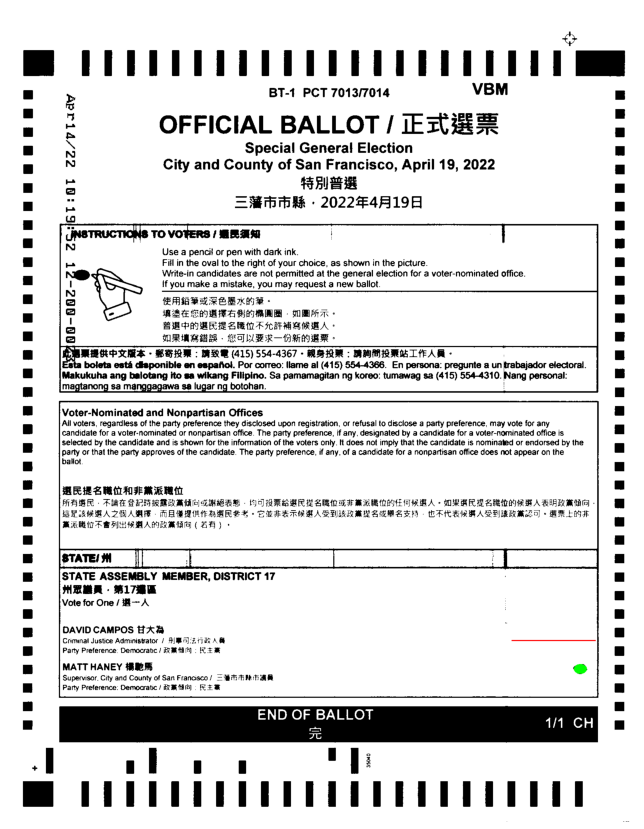

In [6]:
# Visualize data
base_path = "/Users/angelopoulos/Code/working/prediction-powered-inference/ballots/proc/"
ballot_filenames = []
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        if '.png' in filename:
            ballot_filenames += [dirpath + "/" + filename, ]
ballot_filenames = np.array(ballot_filenames)
ballot_filenames = np.random.choice(ballot_filenames, 10)
[find_ellipse(ballot_filename, plot=True) for ballot_filename in ballot_filenames];